***
## Table of Contents
<br>
    <ol><h2><a href='#0' style="text-decoration : none; color : #000000;">1. Loading and Cleaning Data </a></h2> </ol>
    <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">2. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">3. Feature Transformation with feature selection </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">4. Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">5.Over Sampling</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">6.Under Sampling</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
    

In [1]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output,HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import copy

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler,StandardScaler,binarize
from sklearn.ensemble import RandomForestRegressor
# from minepy import MINE
from sklearn import metrics

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score
from sklearn import metrics
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
#     m['Features']=m['Features'].str.replace("dom_function_","")
#     m['Features']=m['Features'].str.replace("js_function_","")
#     m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
#     m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [3]:
def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)
    
    y_pred_train=knn.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the KNN model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=knn.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the KNN model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return knn,cm_train,cm_test,acc_train,acc_test,roc_auc

In [4]:
def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    y_pred_train=log.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Logistic Regression model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=log.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Logistic Regression model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return log,cm_train,cm_test,acc_train,acc_test,roc_auc

In [5]:
def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)
    
    y_pred_train=rf.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Random Forest Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=rf.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Random Forest Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(rf.feature_importances_,feat)
    return rf,cm_train,cm_test,acc_train,acc_test,roc_auc,rf.feature_importances_

In [6]:
def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    y_pred_train=ada.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Ada Boost Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ada.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Ada Boost Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ada.feature_importances_,feat)
    return ada,cm_train,cm_test,acc_train,acc_test,roc_auc,ada.feature_importances_

In [7]:
def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    y_pred_train=gbc.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Gradient Boosting Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=gbc.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Gradient Boosting Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(gbc.feature_importances_,feat)
    return gbc,cm_train,cm_test,acc_train,acc_test,roc_auc,gbc.feature_importances_

In [8]:
def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    y_pred_train=ext_tree.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Extra Tree Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ext_tree.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Extra Tree Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ext_tree.feature_importances_,feat)
    return ext_tree,cm_train,cm_test,acc_train,acc_test,roc_auc,ext_tree.feature_importances_

In [9]:
def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    y_pred_train=bagging.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Bagging model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=bagging.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Bagging model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return bagging,cm_train,cm_test,acc_train,acc_test,roc_auc

In [10]:
def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc

### <a id='0' style="text-decoration : none; color : #000000;"> 1. Loading and Cleaning Data</a>

In [12]:
df_html=pd.read_csv('HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
rem=['link_rel_wlwmanifest','script_src_absolute','base_count','img_src_relative','link_href_relative',
     'form_action_absolute','tbody_count','link_count',  'base_href_absolute', 'img_srcset_relative','link_rel_EditURI',
     'form_enctype_application/x-www-form-urlencoded','a_href_relative','iframe_src_absolute',
     'iframe_sandbox_allow_same_origin_count','a_href_absolute','base_href_relative','link_type_application/wlwmanifest+xml'
     ,'form_action_https','form_action_out_of_domain','nofollow_count','img_count','img_src_http','script_src_http',
     'link_href_http','a_href_http','a_href_out_of_domain','iframe_src_http']
df_html.drop(rem,axis=1,inplace=True)
print("Shape of our dataset:",df_html.shape)
df_html.head()

Shape of our dataset: (43491, 1433)


,a_charset_utf-8,a_count,a_download_download,a_hidden_true,a_href_.7z,a_href_.apk,a_href_.app,a_href_.asp,a_href_.aspx,a_href_.au,a_href_.avi,a_href_.b,a_href_.bin,a_href_.br,a_href_.bz2,a_href_.ca,a_href_.cat,a_href_.cc,a_href_.cfm,a_href_.cgi,a_href_.ch,a_href_.chn,a_href_.cl,a_href_.cms,a_href_.com,a_href_.csp,a_href_.css,a_href_.data,a_href_.de,a_href_.dmg,a_href_.do,a_href_.doc,a_href_.docx,a_href_.dot,a_href_.dz,a_href_.end,a_href_.exe,a_href_.fx,a_href_.gif,a_href_.gsp,a_href_.gz,a_href_.htm,a_href_.html,a_href_.i,a_href_.id,a_href_.io,a_href_.iso,a_href_.it,a_href_.jhtml,a_href_.jpeg,a_href_.jpg,a_href_.js,a_href_.jsf,a_href_.json,a_href_.jsp,a_href_.lnk,a_href_.m3u,a_href_.md,a_href_.me,a_href_.mhp,a_href_.mp3,a_href_.mp4,a_href_.mpl,a_href_.mvc,a_href_.net,a_href_.ogg,a_href_.org,a_href_.pcf,a_href_.pd,a_href_.pdf,a_href_.php,a_href_.phtml,a_href_.pk,a_href_.pl,a_href_.pls,a_href_.png,a_href_.prd,a_href_.pro,a_href_.rar,a_href_.rdf,a_href_.rf,a_href_.rss,a_href_.ru,a_href_.shtml,a_href_.spa,a_href_.svg,a_href_.swf,a_href_.tag,a_href_.tmpl,a_href_.tr,a_href_.tsp,a_href_.tv,a_href_.txt,a_href_.vid,a_href_.wml,a_href_.wmv,a_href_.x,a_href_.xhtml,a_href_.xls,a_href_.xlsx,a_href_.xml,a_href_.xxx,a_href_.xyz,a_href_.xz,a_href_.zip,a_href_0,a_href_0.1,a_href_0.2,a_href_ftp,a_href_https,a_href_irc,a_href_mailto,a_href_script_javascript,a_hreflang_am,a_hreflang_ar,a_hreflang_az,a_hreflang_bs,a_hreflang_ca,a_hreflang_cs,a_hreflang_de,a_hreflang_el,a_hreflang_en,a_hreflang_en-gb,a_hreflang_en-us,a_hreflang_es,a_hreflang_es-ES,a_hreflang_fi,a_hreflang_fr,a_hreflang_hu,a_hreflang_id,a_hreflang_it,a_hreflang_ja,a_hreflang_ko,a_hreflang_ml,a_hreflang_nl,a_hreflang_no,a_hreflang_pl,a_hreflang_pt,a_hreflang_pt-br,a_hreflang_ro,a_hreflang_ru,a_hreflang_sv,a_hreflang_tr,a_hreflang_und,a_hreflang_zh,a_hreflang_zh-hans,a_hreflang_zxx,a_lang_a1,a_lang_ar,a_lang_bg,a_lang_ca,a_lang_cs,a_lang_da,a_lang_de,a_lang_el,a_lang_en,a_lang_en-GB,a_lang_en-US,a_lang_es,a_lang_es-ES,a_lang_fi,a_lang_fr,a_lang_he,a_lang_hi,a_lang_hr,a_lang_hu,a_lang_id,a_lang_it,a_lang_ja,a_lang_ko,a_lang_nl,a_lang_pl,a_lang_pt,a_lang_ro,a_lang_ru,a_lang_sk,a_lang_sv,a_lang_th,a_lang_tr,a_lang_vi,a_lang_zh,a_referrerpolicy_unsafe-url,a_rel_ nofollow,a_rel_ noopener,a_rel_ noopener noreferrer,a_rel_ noreferrer noopener,"a_rel_""nofollow""",a_rel_#modal-overlay,a_rel_#modalExternalSiteCluetip,a_rel_#selectFiliale,a_rel_'nofollow',a_rel_0,a_rel_1,a_rel_10,a_rel_11,a_rel_12,a_rel_13,a_rel_14,a_rel_15,a_rel_16,a_rel_17,a_rel_2,a_rel_3,a_rel_4,a_rel_5,a_rel_6,a_rel_7,a_rel_8,a_rel_9,a_rel_<strong>@font-face Embedding</strong> - this free license allows you to embed the font in your websites with CSS.,a_rel_<strong>Commercial Desktop Use</strong> - this free license allows you to create commercial graphics and documents.,a_rel_Akamai-prefetch,a_rel_Dofollow,a_rel_F,a_rel_Lightbox,a_rel_Menu,a_rel_NOFOLLOW,a_rel__blank,a_rel_about,a_rel_accounts,a_rel_ajaxcontentarea,a_rel_alternate,a_rel_alternate noopener noreferrer,a_rel_archive,a_rel_article,a_rel_attachment,a_rel_author,a_rel_author external,a_rel_author source external,a_rel_blank,a_rel_bookmark,a_rel_bookmark noopener,a_rel_box,a_rel_canonical,a_rel_category,a_rel_category tag,a_rel_category tag noopener noreferrer,a_rel_chapter,a_rel_chartPopup nofollow,a_rel_cklog,a_rel_contact,a_rel_contents,a_rel_countrycontainer,a_rel_date,a_rel_ddsubmenuside1,a_rel_default,a_rel_designer,a_rel_detalis,a_rel_discussion,a_rel_dofollow,...,object_data_.svg,object_data_.swf,object_data_absolute,object_data_http,object_data_https,object_data_out_of_domain,object_data_relative,object_style_display: block; position: absolute; top: 0px; left: 0px; height: 100%; width: 100%; overflow: hidden; pointer-events: none; z-index: -1;,object_style_display: none;,object_type_application/x-shockwave-flash,object_type_image/svg+xml,object_type_text/html,ol_count,optgroup_count,option_count,output_count,p_count,param_count,picture_count,pre_count,pro

In [13]:
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')

cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)

df_js.rename(columns={'Malicious':'Target'},inplace=True)


df_js.drop(['js_function_Object.defineProperty(',
'js_function_Object.keys(',
'js_function_.substr',
'js_function_unescape('
],axis=1,inplace=True)
print("Shape of our dataset:",df_js.shape)
df_js.head()

Shape of our dataset: (43294, 397)


,dom_function_document.adoptNode(,dom_function_document.captureEvents(,dom_function_document.caretPositionFromPoint(,dom_function_document.caretRangeFromPoint(,dom_function_document.clear(,dom_function_document.close(,dom_function_document.createAttribute(,dom_function_document.createAttributeNS(,dom_function_document.createCDATASection(,dom_function_document.createComment(,dom_function_document.createDocumentFragment(,dom_function_document.createElement(,dom_function_document.createElementNS(,dom_function_document.createEntityReference(,dom_function_document.createEvent(,dom_function_document.createNodeIterator(,dom_function_document.createProcessingInstruction(,dom_function_document.createRange(,dom_function_document.createTextNode(,dom_function_document.createTouch(,dom_function_document.createTouchList(,dom_function_document.createTreeWalker(,dom_function_document.elementFromPoint(,dom_function_document.elementsFromPoint(,dom_function_document.enableStyleSheetsForSet(,dom_function_document.execCommand(,dom_function_document.exitPointerLock(,dom_function_document.getAnimations(,dom_function_document.getElementById(,dom_function_document.getElementByName(,dom_function_document.getElementsByClassName(,dom_function_document.getElementsByTagName(,dom_function_document.getElementsByTagNameNS(,dom_function_document.getSelection(,dom_function_document.hasFocus(,dom_function_document.importNode(,dom_function_document.normalizeDocument(,dom_function_document.open(,dom_function_document.queryCommandEnabled(,dom_function_document.queryCommandIndeterm(,dom_function_document.queryCommandValue(,dom_function_document.querySelector(,dom_function_document.querySelectorAll(,dom_function_document.releaseCapture(,dom_function_document.releaseEvent(,dom_function_document.routeEvent(,dom_function_document.write(,dom_function_document.writeln(,dom_function_window.addEventListener(,dom_function_window.alert(,dom_function_window.atob(,dom_function_window.back(,dom_function_window.blur(,dom_function_window.btoa(,dom_function_window.cancelAnimationFrame(,dom_function_window.cancelIdleCallback(,dom_function_window.captureEvents(,dom_function_window.clearImmediate(,dom_function_window.clearInterval(,dom_function_window.clearTimeout(,dom_function_window.close(,dom_function_window.confirm(,dom_function_window.createImageBitmap(,dom_function_window.disableExternalCapture(,dom_function_window.dispatchEvent(,dom_function_window.dump(,dom_function_window.enableExternalCapture(,dom_function_window.fetch(,dom_function_window.find(,dom_function_window.focus(,dom_function_window.forward(,dom_function_window.getAttention(,dom_function_window.getAttentionWithCycleCount(,dom_function_window.getComputedStyle(,dom_function_window.getDefaultComputedSyle(,dom_function_window.getSelection(,dom_function_window.home(,dom_function_window.matchMedia(,dom_function_window.maximize(,dom_function_window.minimize(,dom_function_window.moveBy(,dom_function_window.moveTo(,dom_function_window.open(,dom_function_window.openDialog(,dom_function_window.postMessage(,dom_function_window.print(,dom_function_window.prompt(,dom_function_window.releaseEvents(,dom_function_window.removeEventListener(,dom_function_window.requestAnimationFrame(,dom_function_window.requestIdleCallback(,dom_function_window.resizeBy(,dom_function_window.resizeTo(,dom_function_window.restore(,dom_function_window.routeEvent(,dom_function_window.scroll(,dom_function_window.scrollBy(,dom_function_window.scrollByLines(,dom_function_window.scrollByPages(,dom_function_window.scrollTo(,dom_function_window.setCursor(,dom_function_window.setImmediate(,dom_function_window.setInterval(,dom_function_window.setResizable(,dom_function_window.setTimeout(,dom_function_window.sizeToContent(,dom_function_window.stop(,dom_function_window.updateCommands(,js_function_.add(,js_function_.all(,js_function_.allTrue(,js_function_.anchor(,js_function_.apply(,js_function_.big(,js_function_.bind(,js_function_.blink(,js_function_.bold(,js_funct

In [14]:
col_js_no_uni=remove_feat(df_js)
col_html_no_uni=remove_feat(df_html)

In [15]:
print("{} columns in JavaScript experiment with all missing or only one unique value".format(len(col_js_no_uni)))
print("{} columns in HTML experiment with all missing or only one unique value".format(len(col_html_no_uni)))

113 columns in JavaScript experiment with all missing or only one unique value
0 columns in HTML experiment with all missing or only one unique value


In [16]:
df_js.drop(col_js_no_uni,axis=1,inplace=True)
df_html.drop(col_html_no_uni,axis=1,inplace=True)

In [17]:
print("Shape of JavaScript experiemtn after dropping them:",df_js.shape)
print("Shape of HTML experiemtn after dropping them:",df_html.shape)

Shape of JavaScript experiemtn after dropping them: (43294, 284)
Shape of HTML experiemtn after dropping them: (43491, 1433)


In [18]:
col_js_95=uni_value(df_js)
col_html_95=uni_value(df_html)
print("{} columns in JavaScript experiment with more than 95% same values".format(len(col_js_95[col_js_95['95_%_same_values']==True])))
print("{} columns in HTML experiment with more than 95% same values".format(len(col_html_95[col_html_95['95_%_same_values']==True])))

234 columns in JavaScript experiment with more than 95% same values
1297 columns in HTML experiment with more than 95% same values


In [19]:
### Lets drop those columns
df_js.drop(col_js_95[col_js_95['95_%_same_values']==True].index.values,axis=1,inplace=True)

df_html.drop(col_html_95[col_html_95['95_%_same_values']==True].index.values,axis=1,inplace=True)

print("Shape of JavaScript experiment after dropping them:",df_js.shape)
print("Shape of HTML experiment after dropping them:",df_html.shape)

Shape of JavaScript experiment after dropping them: (43294, 50)
Shape of HTML experiment after dropping them: (43491, 136)


#### Let us analyze the balance of classes

In [20]:
class_bal(df_js,'JavaScript experiment')
class_bal(df_html,'HTML experiment')

#### Analyzing the categorical and numerical features

In [21]:
cat_var_js,num_var_js=check_cat(df_js)
cat_var_html,num_var_html=check_cat(df_html)

In [22]:
df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)

print("Stats for numerical features for JavaScript experiment\n")
num_stats_js=num_stats(df_js,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for JavaScript experiment\n")
cat_stats_js=cat_stats(df_js,cat_var_js)
display(cat_stats_js)

Stats for numerical features for JavaScript experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
dom_function_document.getElementsByTagName(,-0.206833,0.000000e+00,-94.422955,0.000000e+00
dom_function_document.createElement(,-0.154604,9.233651e-230,-72.422095,0.000000e+00
js_function_.getTime(,-0.149504,8.006211e-215,-70.045384,0.000000e+00
dom_function_window.addEventListener(,-0.107093,1.299881e-110,-51.397683,0.000000e+00
js_function_.split(,-0.097541,5.300145e-92,-46.252895,0.000000e+00
js_function_Math.random(,-0.094978,2.620317e-87,-44.513654,0.000000e+00
js_function_.setTime(,-0.083818,2.410642e-68,-41.813198,0.000000e+00
js_function_.replace(,-0.087844,6.536777e-75,-38.924200,0.000000e+00
js_function_.indexOf(,-0.075600,6.618535e-56,-36.469099,9.453374e-287



Stats for Categorical features for JavaScript experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,


In [23]:
print("Stats for numerical features for HTML experiment\n")
num_stats_html=num_stats(df_html,num_var_html)
display(num_stats_html)
print("\nStats for Categorical features for HTML experiment\n")
cat_stats_html=cat_stats(df_html,cat_var_html)
display(cat_stats_html)

Stats for numerical features for HTML experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
script_src_.js,-0.319546,0.000000e+00,-142.596194,0.000000e+00
script_count,-0.315619,0.000000e+00,-142.448699,0.000000e+00
script_src_relative,-0.310931,0.000000e+00,-135.577261,0.000000e+00
script_src_https,-0.271077,0.000000e+00,-126.553948,0.000000e+00
script_async_true,-0.245742,0.000000e+00,-118.214320,0.000000e+00
link_rel_canonical,-0.276351,0.000000e+00,-114.117813,0.000000e+00
div_count,-0.231558,0.000000e+00,-113.026088,0.000000e+00
script_type_text/javascript,-0.264055,0.000000e+00,-111.582561,0.000000e+00
script_src_out_of_domain,-0.246691,0.000000e+00,-106.660880,0.000000e+00



Stats for Categorical features for HTML experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,


In [24]:
fin_col=num_stats_js.index.values[0:25].tolist()+cat_stats_js.index.values[0:25].tolist() + num_stats_html.index.values[0:25].tolist()+cat_stats_html.index.values[0:25].tolist() 

#### We can see from the graph that there is high imbalance in the dataset. We can handle it either by oversampling, undersampling or tuning our models to focus on recall/precision to address the problem

#### Cleaning and analyzing the dataset.


#### We know that many of the features will all have no more than one unique value. Hence, we will first identify and drop those features

#### Columns which have do not have any unique values

In [25]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [26]:
print("Features we will be using:")
display(fin_col)

Features we will be using:


['dom_function_document.getElementsByTagName(',
 'dom_function_document.createElement(',
 'js_function_.getTime(',
 'dom_function_window.addEventListener(',
 'js_function_.split(',
 'js_function_Math.random(',
 'js_function_.setTime(',
 'js_function_.replace(',
 'js_function_.indexOf(',
 'js_function_Math.floor(',
 'js_function_decodeURIComponent(',
 'js_function_.match(',
 'js_function_JSON.parse(',
 'js_function_.pop(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_encodeURIComponent(',
 'js_function_.test(',
 'js_function_.apply(',
 'js_function_Math.round(',
 'js_function_.substring(',
 'js_function_.shift(',
 'js_function_.join(',
 'js_function_.push(',
 'dom_function_document.getElementById(',
 'script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'meta_http-equiv_X-UA-Compatible',
 'link_

In [27]:
df_int=pd.merge(df_js,df_html,left_index=True,right_index=True)

df=df_int.copy(deep=True)

df['Target']=df[['Target_x','Target_y']].apply(max,axis=1)

In [28]:
columns=copy.deepcopy(fin_col)
fin_col.append('Target')

df_sel=df[fin_col]

display(df_sel.shape)

(40709, 51)

In [29]:
class_bal(df_sel,'Combined experiments')

In [30]:
### Preparing our training and test sets
X=df_sel.iloc[:,df_sel.columns!='Target'].values
y=df_sel.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [31]:
f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

In [32]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [33]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.89692019529
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24930  2932    27862
True         425  4280     4705
__all__    25355  7212    32567

Accuracy of the KNN model for twst data is: 0.894988946205
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6183   733     6916
True         122  1104     1226
__all__     6305  1837     8142



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.852918598581
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27693   169    27862
True        4621    84     4705
__all__    32314   253    32567

Accuracy of the Logistic Regression model for twst data is: 0.84831736674
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6873    43     6916
True        1192    34     1226
__all__     8065    77     8142



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.90901833144
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25032  2830    27862
True         133  4572     4705
__all__    25165  7402    32567

Accuracy of the Random Forest Classifier for twst data is: 0.898427904692
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6205   711     6916
True         116  1110     1226
__all__     6321  1821     8142



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.876255104861
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24659  3203    27862
True         827  3878     4705
__all__    25486  7081    32567

Accuracy of the Ada Boost Classifier for twst data is: 0.878039793662
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6119   797     6916
True         196  1030     1226
__all__     6315  1827     8142



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.894340897227
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24978  2884    27862
True         557  4148     4705
__all__    25535  7032    32567

Accuracy of the Gradient Boosting Classifier for twst data is: 0.89118152788
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6193   723     6916
True         163  1063     1226
__all__     6356  1786     8142



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.91079927534
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25018  2844    27862
True          61  4644     4705
__all__    25079  7488    32567

Accuracy of the Extra Tree Classifier for twst data is: 0.89879636453
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6203   713     6916
True         111  1115     1226
__all__     6314  1828     8142



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.9085577425
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25029  2833    27862
True         145  4560     4705
__all__    25174  7393    32567

Accuracy of the Bagging model for twst data is: 0.897445345124
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6194   722     6916
True         113  1113     1226
__all__     6307  1835     8142



Neural Network-1
The accuracy of the model on training data is: 0.895262075121


Predicted  False  True  __all__
Actual                         
False      24633  3229    27862
True         182  4523     4705
__all__    24815  7752    32567

The accuracy of the model on test data is: 0.883566691231


Predicted  False  True  __all__
Actual                         
False       6086   830     6916
True         118  1108     1226
__all__     6204  1938     8142

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [34]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [35]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.896920,4280.0,24930.0,2932.0,425.0,0.105233,0.090329
LogisticRegression,0.852919,84.0,27693.0,169.0,4621.0,0.006066,0.982147
RandomForestClassifier,0.909018,4572.0,25032.0,2830.0,133.0,0.101572,0.028268
AdaBoostClassifier,0.876255,3878.0,24659.0,3203.0,827.0,0.114959,0.175770
GradientBoostingClassifier,0.894341,4148.0,24978.0,2884.0,557.0,0.103510,0.118385
ExtraTreeClassifier,0.910799,4644.0,25018.0,2844.0,61.0,0.102075,0.012965
BaggingClassifier,0.908558,4560.0,25029.0,2833.0,145.0,0.101680,0.030818
Neural Network-1,0.895262,4523.0,24633.0,3229.0,182.0,0.115893,0.038682


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.894989,1104.0,6183.0,733.0,122.0,0.105986,0.099511,0.897252
LogisticRegression,0.848317,34.0,6873.0,43.0,1192.0,0.006217,0.972268,0.510757
RandomForestClassifier,0.898428,1110.0,6205.0,711.0,116.0,0.102805,0.094617,0.901289
AdaBoostClassifier,0.878040,1030.0,6119.0,797.0,196.0,0.115240,0.159869,0.862445
GradientBoostingClassifier,0.891182,1063.0,6193.0,723.0,163.0,0.104540,0.132953,0.881254
ExtraTreeClassifier,0.898796,1115.0,6203.0,713.0,111.0,0.103094,0.090538,0.903184
BaggingClassifier,0.897445,1113.0,6194.0,722.0,113.0,0.104396,0.092170,0.901717
Neural Network-1,0.883567,1108.0,6086.0,830.0,118.0,0.120012,0.096248,0.901717


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [38]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 3. Feature Transformation with feature selection</a>

In [39]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [40]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

Entityset: malicious
  Entities:
    data [Rows: 40709, Columns: 51]
  Relationships:
    No relationships

In [41]:
feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 4950 features
EntitySet scattered to workers in 5.592 seconds
Elapsed: 00:34 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


#### Lets have a look at the feature set generated

In [42]:
feature_matrix_sessions.head()

,dom_function_document.getElementsByTagName(,dom_function_document.createElement(,js_function_.getTime(,dom_function_window.addEventListener(,js_function_.split(,js_function_Math.random(,js_function_.setTime(,js_function_.replace(,js_function_.indexOf(,js_function_Math.floor(,js_function_decodeURIComponent(,js_function_.match(,js_function_JSON.parse(,js_function_.pop(,js_function_.charAt(,js_function_.concat(,js_function_encodeURIComponent(,js_function_.test(,js_function_.apply(,js_function_Math.round(,js_function_.substring(,js_function_.shift(,js_function_.join(,js_function_.push(,dom_function_document.getElementById(,script_src_.js,script_count,script_src_relative,script_src_https,script_async_true,link_rel_canonical,div_count,script_type_text/javascript,script_src_out_of_domain,iframe_count,a_count,meta_http-equiv_X-UA-Compatible,link_href_https,img_src_absolute,img_src_https,iframe_src_relative,link_rel_shortcut icon,iframe_src_https,a_href_https,link_href_.ico,link_href_absolute,link_rel_stylesheet,img_src_.jpg,link_rel_icon,img_src_out_of_domain,js_function_.pop( + js_function_.split(,div_count + js_function_Math.round(,js_function_.concat( + script_count,iframe_src_https + script_src_https,js_function_.join( + meta_http-equiv_X-UA-Compatible,dom_function_window.addEventListener( + js_function_Math.floor(,js_function_Math.round( + link_rel_shortcut icon,a_href_https + img_src_.jpg,js_function_.setTime( + script_src_.js,js_function_.test( + js_function_JSON.parse(,js_function_.shift( + js_function_.split(,js_function_.indexOf( + link_href_.ico,js_function_.substring( + script_src_.js,js_function_.setTime( + js_function_encodeURIComponent(,dom_function_document.createElement( + js_function_.split(,js_function_.replace( + js_function_decodeURIComponent(,link_href_absolute + script_src_https,iframe_count + js_function_.concat(,a_href_https + link_rel_stylesheet,js_function_Math.floor( + script_src_out_of_domain,js_function_.charAt( + link_rel_stylesheet,img_src_https + img_src_out_of_domain,img_src_.jpg + script_src_.js,js_function_.join( + js_function_.push(,js_function_.substring( + js_function_encodeURIComponent(,js_function_.replace( + js_function_Math.floor(,link_rel_canonical + link_rel_shortcut icon,div_count + script_src_https,js_function_.push( + link_href_.ico,dom_function_document.getElementById( + js_function_.apply(,a_href_https + js_function_.join(,dom_function_document.getElementsByTagName( + link_rel_icon,js_function_.join( + js_function_.shift(,a_href_https + js_function_.pop(,js_function_.substring( + js_function_JSON.parse(,link_rel_shortcut icon + meta_http-equiv_X-UA-Compatible,img_src_https + js_function_.replace(,dom_function_document.getElementById( + link_rel_icon,iframe_src_relative + js_function_.replace(,js_function_.charAt( + script_count,js_function_.setTime( + js_function_JSON.parse(,js_function_.join( + js_function_.pop(,img_src_absolute + js_function_.replace(,meta_http-equiv_X-UA-Compatible + script_src_relative,js_function_.shift( + link_href_.ico,iframe_src_relative + link_rel_icon,dom_function_window.addEventListener( + link_rel_icon,div_count + dom_function_window.addEventListener(,img_src_.jpg + js_function_.substring(,link_href_https + script_type_text/javascript,img_src_absolute + js_function_Math.floor(,a_count + img_src_.jpg,js_function_.pop( + link_rel_stylesheet,dom_function_document.getElementById( + js_function_encodeURIComponent(,dom_function_window.addEventListener( + link_rel_shortcut icon,js_function_.getTime( + link_rel_shortcut icon,js_function_.match( + link_rel_shortcut icon,js_function_Math.floor( + link_href_.ico,iframe_src_https + link_rel_canonical,iframe_count + js_function_.push(,js_function_.replace( + script_async_true,js_function_.pop( + js_function_JSON.parse(,js_function_.push( + script_src_out_of_domain,iframe_src_https + js_function_.substring(,div_count + js_function_JSON.parse(,a_href_https + js_function_Math.floor(,iframe_count + meta_http-equiv_X-UA-Com

In [43]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

#### Now we have a very huge feature-set and generally more features can cause over-fitting. Hence, we will use a combination of feature selection techniques to select only a few from them.

In [44]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [45]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [46]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [47]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [48]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [49]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [52]:
X=fs[feature_selection_df[feature_selection_df.Total>=2]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(40709, 88)

In [53]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['script_src_out_of_domain / script_src_relative',
 'script_src_https / script_src_relative',
 'script_src_.js / script_src_relative',
 'script_src_.js / script_count',
 'script_count + script_src_.js',
 'script_async_true / script_count',
 'link_rel_stylesheet + script_src_.js',
 'js_function_.shift( + script_src_.js',
 'img_src_out_of_domain / img_src_absolute',
 'a_href_https / a_count',
 'script_type_text/javascript / script_count',
 'script_src_relative / script_count',
 'script_src_out_of_domain / script_count',
 'script_src_https / script_count',
 'script_src_.js + script_src_relative',
 'script_src_.js + script_src_out_of_domain',
 'script_src_.js',
 'script_count / script_src_relative',
 'script_count + script_src_relative',
 'script_count + script_src_https',
 'script_count',
 'meta_http-equiv_X-UA-Compatible / script_src_out_of_domain',
 'meta_http-equiv_X-UA-Compatible + script_src_.js',
 'link_rel_stylesheet / script_src_https',
 'link_rel_stylesheet / link_href_absolute',

In [54]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [55]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.896183252986
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24855  2950    27805
True         431  4331     4762
__all__    25286  7281    32567

Accuracy of the KNN model for twst data is: 0.889953328421
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6217   756     6973
True         140  1029     1169
__all__     6357  1785     8142



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.88076887647
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24623  3182    27805
True         701  4061     4762
__all__    25324  7243    32567

Accuracy of the Logistic Regression model for twst data is: 0.878039793662
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6160   813     6973
True         180   989     1169
__all__     6340  1802     8142



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.906469739307
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24917  2888    27805
True         158  4604     4762
__all__    25075  7492    32567

Accuracy of the Random Forest Classifier for twst data is: 0.89240972734
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6229   744     6973
True         132  1037     1169
__all__     6361  1781     8142



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.880124051954
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24466  3339    27805
True         565  4197     4762
__all__    25031  7536    32567

Accuracy of the Ada Boost Classifier for twst data is: 0.876934414149
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6126   847     6973
True         155  1014     1169
__all__     6281  1861     8142



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.893081954125
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24869  2936    27805
True         546  4216     4762
__all__    25415  7152    32567

Accuracy of the Gradient Boosting Classifier for twst data is: 0.886145910096
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6218   755     6973
True         172   997     1169
__all__     6390  1752     8142



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.908219977278
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24929  2876    27805
True         113  4649     4762
__all__    25042  7525    32567

Accuracy of the Extra Tree Classifier for twst data is: 0.892655367232
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6227   746     6973
True         128  1041     1169
__all__     6355  1787     8142



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.906101268155
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24902  2903    27805
True         155  4607     4762
__all__    25057  7510    32567

Accuracy of the Bagging model for twst data is: 0.89179562761
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6220   753     6973
True         128  1041     1169
__all__     6348  1794     8142



Neural Network-1
The accuracy of the model on training data is: 0.893788190487


Predicted  False  True  __all__
Actual                         
False      24520  3285    27805
True         174  4588     4762
__all__    24694  7873    32567

The accuracy of the model on test data is: 0.881478752149


Predicted  False  True  __all__
Actual                         
False       6118   855     6973
True         110  1059     1169
__all__     6228  1914     8142

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [56]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [57]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.896183,4331.0,24855.0,2950.0,431.0,0.106096,0.090508
LogisticRegression,0.880769,4061.0,24623.0,3182.0,701.0,0.114440,0.147207
RandomForestClassifier,0.906470,4604.0,24917.0,2888.0,158.0,0.103866,0.033179
AdaBoostClassifier,0.880124,4197.0,24466.0,3339.0,565.0,0.120086,0.118648
GradientBoostingClassifier,0.893082,4216.0,24869.0,2936.0,546.0,0.105593,0.114658
ExtraTreeClassifier,0.908220,4649.0,24929.0,2876.0,113.0,0.103435,0.023730
BaggingClassifier,0.906101,4607.0,24902.0,2903.0,155.0,0.104406,0.032549
Neural Network-1,0.893788,4588.0,24520.0,3285.0,174.0,0.118144,0.036539


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.889953,1029.0,6217.0,756.0,140.0,0.108418,0.119760,0.885911
LogisticRegression,0.878040,989.0,6160.0,813.0,180.0,0.116593,0.153978,0.864715
RandomForestClassifier,0.892410,1037.0,6229.0,744.0,132.0,0.106697,0.112917,0.890193
AdaBoostClassifier,0.876934,1014.0,6126.0,847.0,155.0,0.121469,0.132592,0.872970
GradientBoostingClassifier,0.886146,997.0,6218.0,755.0,172.0,0.108275,0.147134,0.872295
ExtraTreeClassifier,0.892655,1041.0,6227.0,746.0,128.0,0.106984,0.109495,0.891760
BaggingClassifier,0.891796,1041.0,6220.0,753.0,128.0,0.107988,0.109495,0.891258
Neural Network-1,0.881479,1059.0,6118.0,855.0,110.0,0.122616,0.094098,0.891258


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [77]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

#### In Section 2.1, we reduced the feature set by perfroming feature selection. Alternatively we can make use of dimensionality rediction techniques such as PCA. Let us see how it fares

### <a id='3' style="text-decoration : none; color : #000000;"> 4. Feature Transformation with PCA</a>

In [66]:
X=fs.loc[:,df.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

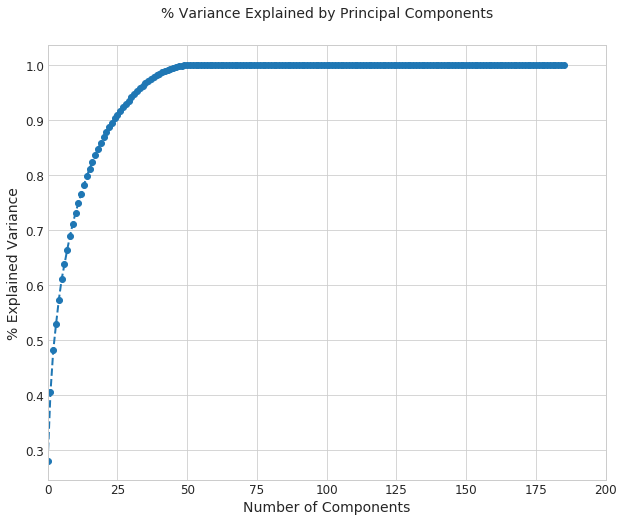

In [67]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [68]:
n=np.where(np.cumsum(pca.explained_variance_ratio_)>=0.99)[0][0]

In [69]:
pca=PCA(n_components=n,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using {} components is {}".format(n,sum(pca.explained_variance_ratio_)))

Variance explained using 43 components is 0.989503129099999


In [70]:
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_21,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [71]:
## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [72]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,n).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.870543802008
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27583   222    27805
True        3994   768     4762
__all__    31577   990    32567

Accuracy of the KNN model for twst data is: 0.86747727831
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6906    67     6973
True        1012   157     1169
__all__     7918   224     8142



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.875272515123
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24700  3105    27805
True         957  3805     4762
__all__    25657  6910    32567

Accuracy of the Logistic Regression model for twst data is: 0.876074674527
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6191   782     6973
True         227   942     1169
__all__     6418  1724     8142



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.908956919581
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24957  2848    27805
True         117  4645     4762
__all__    25074  7493    32567

Accuracy of the Random Forest Classifier for twst data is: 0.896585605502
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6250   723     6973
True         119  1050     1169
__all__     6369  1773     8142



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.886234531888
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24754  3051    27805
True         654  4108     4762
__all__    25408  7159    32567

Accuracy of the Ada Boost Classifier for twst data is: 0.884917710636
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6204   769     6973
True         168  1001     1169
__all__     6372  1770     8142



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.896398194491
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24992  2813    27805
True         561  4201     4762
__all__    25553  7014    32567

Accuracy of the Gradient Boosting Classifier for twst data is: 0.891672807664
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6257   716     6973
True         166  1003     1169
__all__     6423  1719     8142



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.911106334633
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24983  2822    27805
True          73  4689     4762
__all__    25056  7511    32567

Accuracy of the Extra Tree Classifier for twst data is: 0.896094325718
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6254   719     6973
True         127  1042     1169
__all__     6381  1761     8142



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.908588448429
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24957  2848    27805
True         129  4633     4762
__all__    25086  7481    32567

Accuracy of the Bagging model for twst data is: 0.896217145664
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6245   728     6973
True         117  1052     1169
__all__     6362  1780     8142



Neural Network-1
The accuracy of the model on training data is: 0.901710320243


Predicted  False  True  __all__
Actual                         
False      24741  3064    27805
True         137  4625     4762
__all__    24878  7689    32567

The accuracy of the model on test data is: 0.885777450258


Predicted  False  True  __all__
Actual                         
False       6147   826     6973
True         104  1065     1169
__all__     6251  1891     8142

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [73]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [74]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.870544,768.0,27583.0,222.0,3994.0,0.007984,0.838723
LogisticRegression,0.875273,3805.0,24700.0,3105.0,957.0,0.111671,0.200966
RandomForestClassifier,0.908957,4645.0,24957.0,2848.0,117.0,0.102428,0.024570
AdaBoostClassifier,0.886235,4108.0,24754.0,3051.0,654.0,0.109728,0.137337
GradientBoostingClassifier,0.896398,4201.0,24992.0,2813.0,561.0,0.101169,0.117808
ExtraTreeClassifier,0.911106,4689.0,24983.0,2822.0,73.0,0.101493,0.015330
BaggingClassifier,0.908588,4633.0,24957.0,2848.0,129.0,0.102428,0.027089
Neural Network-1,0.901710,4625.0,24741.0,3064.0,137.0,0.110196,0.028769


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.867477,157.0,6906.0,67.0,1012.0,0.009608,0.865697,0.562347
LogisticRegression,0.876075,942.0,6191.0,782.0,227.0,0.112147,0.194183,0.846835
RandomForestClassifier,0.896586,1050.0,6250.0,723.0,119.0,0.103686,0.101796,0.897259
AdaBoostClassifier,0.884918,1001.0,6204.0,769.0,168.0,0.110283,0.143713,0.873002
GradientBoostingClassifier,0.891673,1003.0,6257.0,716.0,166.0,0.102682,0.142002,0.877658
ExtraTreeClassifier,0.896094,1042.0,6254.0,719.0,127.0,0.103112,0.108640,0.894124
BaggingClassifier,0.896217,1052.0,6245.0,728.0,117.0,0.104403,0.100086,0.897756
Neural Network-1,0.885777,1065.0,6147.0,826.0,104.0,0.118457,0.088965,0.897756


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [87]:
feat_impt_plot(np.average(feat_imp,axis=0),np.arange(0,n).astype(str))

### <a id='4' style="text-decoration : none; color : #000000;"> 5. Over Sampling</a>

In [75]:
# fin_col.remove('Target')
# columns=fin_col
print("Features we will be using:")
display(columns)

Features we will be using:


['dom_function_document.getElementsByTagName(',
 'dom_function_document.createElement(',
 'js_function_.getTime(',
 'dom_function_window.addEventListener(',
 'js_function_.split(',
 'js_function_Math.random(',
 'js_function_.setTime(',
 'js_function_.replace(',
 'js_function_.indexOf(',
 'js_function_Math.floor(',
 'js_function_decodeURIComponent(',
 'js_function_.match(',
 'js_function_JSON.parse(',
 'js_function_.pop(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_encodeURIComponent(',
 'js_function_.test(',
 'js_function_.apply(',
 'js_function_Math.round(',
 'js_function_.substring(',
 'js_function_.shift(',
 'js_function_.join(',
 'js_function_.push(',
 'dom_function_document.getElementById(',
 'script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'meta_http-equiv_X-UA-Compatible',
 'link_

In [77]:
### Preparing our training and test sets
columns.remove('domain')
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

The train/test split ratio is 80:20


In [79]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [80]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.595560261288
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27054   808    27862
True       21729  6133    27862
__all__    48783  6941    55724

Accuracy of the KNN model for twst data is: 0.846229427659
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6677   239     6916
True        1013   213     1226
__all__     7690   452     8142



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.883515181968
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22476   5386    27862
True        1105  26757    27862
__all__    23581  32143    55724

Accuracy of the Logistic Regression model for twst data is: 0.833456153279
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5606  1310     6916
True          46  1180     1226
__all__     5652  2490     8142



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.946450362501
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24928   2934    27862
True          50  27812    27862
__all__    24978  30746    55724

Accuracy of the Random Forest Classifier for twst data is: 0.897936624908
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6180   736     6916
True          95  1131     1226
__all__     6275  1867     8142



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.899684157634
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23539   4323    27862
True        1267  26595    27862
__all__    24806  30918    55724

Accuracy of the Ada Boost Classifier for twst data is: 0.866494718742
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5897  1019     6916
True          68  1158     1226
__all__     5965  2177     8142



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.92249300122
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24255   3607    27862
True         712  27150    27862
__all__    24967  30757    55724

Accuracy of the Gradient Boosting Classifier for twst data is: 0.881724392041
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6036   880     6916
True          83  1143     1226
__all__     6119  2023     8142



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.947060512526
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24936   2926    27862
True          24  27838    27862
__all__    24960  30764    55724

Accuracy of the Extra Tree Classifier for twst data is: 0.897445345124
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6182   734     6916
True         101  1125     1226
__all__     6283  1859     8142



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.945983777188
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24924   2938    27862
True          72  27790    27862
__all__    24996  30728    55724

Accuracy of the Bagging model for twst data is: 0.894497666421
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6141   775     6916
True          84  1142     1226
__all__     6225  1917     8142



Neural Network-1
The accuracy of the model on training data is: 0.935001076735


Predicted  False   True  __all__
Actual                          
False      24410   3452    27862
True         170  27692    27862
__all__    24580  31144    55724

The accuracy of the model on test data is: 0.88025055269


Predicted  False  True  __all__
Actual                         
False       6010   906     6916
True          69  1157     1226
__all__     6079  2063     8142

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [81]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [82]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.595560,6133.0,27054.0,808.0,21729.0,0.029000,0.779879
LogisticRegression,0.883515,26757.0,22476.0,5386.0,1105.0,0.193310,0.039660
RandomForestClassifier,0.946450,27812.0,24928.0,2934.0,50.0,0.105305,0.001795
AdaBoostClassifier,0.899684,26595.0,23539.0,4323.0,1267.0,0.155158,0.045474
GradientBoostingClassifier,0.922493,27150.0,24255.0,3607.0,712.0,0.129459,0.025555
ExtraTreeClassifier,0.947061,27838.0,24936.0,2926.0,24.0,0.105018,0.000861
BaggingClassifier,0.945984,27790.0,24924.0,2938.0,72.0,0.105448,0.002584
Neural Network-1,0.935001,27692.0,24410.0,3452.0,170.0,0.123896,0.006102


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.846229,213.0,6677.0,239.0,1013.0,0.034558,0.826264,0.569589
LogisticRegression,0.833456,1180.0,5606.0,1310.0,46.0,0.189416,0.037520,0.886532
RandomForestClassifier,0.897937,1131.0,6180.0,736.0,95.0,0.106420,0.077488,0.908046
AdaBoostClassifier,0.866495,1158.0,5897.0,1019.0,68.0,0.147340,0.055465,0.898598
GradientBoostingClassifier,0.881724,1143.0,6036.0,880.0,83.0,0.127241,0.067700,0.902529
ExtraTreeClassifier,0.897445,1125.0,6182.0,734.0,101.0,0.106131,0.082382,0.905744
BaggingClassifier,0.894498,1142.0,6141.0,775.0,84.0,0.112059,0.068515,0.909713
Neural Network-1,0.880251,1157.0,6010.0,906.0,69.0,0.131001,0.056281,0.909713


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [83]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='5' style="text-decoration : none; color : #000000;"> 6. Under Sampling</a>

In [84]:
df_non=df[df.Target==0]
df_mal=df[df.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X=df_u[columns]
y=df_u.Target.values

feature_name = X.columns.tolist()
print("Shape after undersampling",df_u.shape)
df_u.head()

Shape after undersampling (11862, 187)


,dom_function_document.createElement(,dom_function_document.getElementById(,dom_function_document.getElementsByTagName(,dom_function_document.querySelector(,dom_function_document.write(,dom_function_window.addEventListener(,dom_function_window.open(,dom_function_window.setTimeout(,js_function_.add(,js_function_.apply(,js_function_.bind(,js_function_.call(,js_function_.charAt(,js_function_.concat(,js_function_.defineProperty(,js_function_.exec(,js_function_.find(,js_function_.forEach(,js_function_.get(,js_function_.getTime(,js_function_.hasOwnProperty(,js_function_.indexOf(,js_function_.join(,js_function_.keys(,js_function_.log(,js_function_.match(,js_function_.pop(,js_function_.push(,js_function_.replace(,js_function_.setTime(,js_function_.shift(,js_function_.slice(,js_function_.split(,js_function_.substring(,js_function_.test(,js_function_.toLowerCase(,js_function_.toString(,js_function_.trim(,js_function_JSON.parse(,js_function_JSON.stringify(,js_function_Math.floor(,js_function_Math.max(,js_function_Math.random(,js_function_Math.round(,js_function_decodeURIComponent(,js_function_encodeURIComponent(,js_function_escape(,js_function_isNaN(,js_function_parseInt(,Target_x,a_count,a_href_.aspx,a_href_.com,a_href_.htm,a_href_.html,a_href_.pdf,a_href_.php,a_href_0,a_href_https,a_href_mailto,a_href_script_javascript,a_rel_nofollow,article_count,aside_count,b_count,base_href_out_of_domain,br_count,button_count,center_count,dd_count,div_count,dl_count,dt_count,em_count,fieldset_count,figure_count,font_count,footer_count,form_action_.php,form_action_http,form_action_relative,form_count,h1_count,header_count,hr_count,i_count,iframe_count,iframe_sandbox_allow_scripts_count,iframe_src_.com,iframe_src_.html,iframe_src_0,iframe_src_https,iframe_src_out_of_domain,iframe_src_relative,img_src_.gif,img_src_.jpeg,img_src_.jpg,img_src_.png,img_src_.svg,img_src_0,img_src_absolute,img_src_https,img_src_out_of_domain,img_srcset_absolute,img_srcset_https,img_srcset_out_of_domain,input_count,ins_count,label_count,li_count,link_href_.com,link_href_.css,link_href_.ico,link_href_.json,link_href_.php,link_href_.png,link_href_.xml,link_href_0,link_href_absolute,link_href_https,link_href_out_of_domain,link_rel_alternate,link_rel_apple-touch-icon,link_rel_apple-touch-icon-precomposed,link_rel_canonical,link_rel_dns-prefetch,link_rel_https://api.w.org/,link_rel_icon,link_rel_manifest,link_rel_next,link_rel_pingback,link_rel_preload,link_rel_profile,link_rel_publisher,link_rel_shortcut icon,link_rel_shortlink,link_rel_stylesheet,link_type_application/rsd+xml,link_type_application/rss+xml,link_type_image/png,link_type_image/x-icon,link_type_text/css,main_count,meta_charset_UTF-8,meta_charset_utf-8,meta_count,meta_http-equiv_Content-Type,meta_http-equiv_X-UA-Compatible,meta_http-equiv_content-type,nav_count,noopener_count,noscript_count,ol_count,option_count,p_count,script_async_true,script_charset_UTF-8,script_charset_utf-8,script_count,script_crossorigin_anonymous,script_defer_true,script_language_JavaScript,script_language_javascript,script_src_.com,script_src_.js,script_src_0,script_src_https,script_src_out_of_domain,script_src_relative,script_type_application/ld+json,script_type_text/javascript,section_count,select_count,small_count,source_count,span_count,strong_count,style_count,table_count,td_count,textarea_count,time_count,title_count,tr_count,ul_count,Target_y,Target
domain,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
vpnmentor.com,2.0,0.0,5.0,0.0,0.0,1.0,4.0,3.0,0.0,3.0,6.0,9.0,0.0,3.0,1.0,0.0,0.0,0.0,4.0,4.0,1.0,26.0,12.0,0.0,0.0,0.0,1.0,10.0,0.0,0.0,2.0,0.0,14.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,8.0,4.0,1.0,0.0,1.0,0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,177.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,0.0,0.0,197.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,0.0,1.0,0.0,71.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0

In [85]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)


The train/test split ratio is 80:20


In [86]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [87]:
print('Features we will be using:\n')
display(columns)

Features we will be using:



['dom_function_document.getElementsByTagName(',
 'dom_function_document.createElement(',
 'js_function_.getTime(',
 'dom_function_window.addEventListener(',
 'js_function_.split(',
 'js_function_Math.random(',
 'js_function_.setTime(',
 'js_function_.replace(',
 'js_function_.indexOf(',
 'js_function_Math.floor(',
 'js_function_decodeURIComponent(',
 'js_function_.match(',
 'js_function_JSON.parse(',
 'js_function_.pop(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_encodeURIComponent(',
 'js_function_.test(',
 'js_function_.apply(',
 'js_function_Math.round(',
 'js_function_.substring(',
 'js_function_.shift(',
 'js_function_.join(',
 'js_function_.push(',
 'dom_function_document.getElementById(',
 'script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'meta_http-equiv_X-UA-Compatible',
 'link_

In [88]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.912741068606
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4179   593     4772
True         235  4482     4717
__all__     4414  5075     9489

Accuracy of the KNN model for twst data is: 0.889591234724
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        975   184     1159
True          78  1136     1214
__all__     1053  1320     2373



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.884181684055
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3862   910     4772
True         189  4528     4717
__all__     4051  5438     9489

Accuracy of the Logistic Regression model for twst data is: 0.869363674673
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        907   252     1159
True          58  1156     1214
__all__      965  1408     2373



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.945199704921
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4286   486     4772
True          34  4683     4717
__all__     4320  5169     9489

Accuracy of the Random Forest Classifier for twst data is: 0.898862199747
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        992   167     1159
True          73  1141     1214
__all__     1065  1308     2373



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.895352513437
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4052   720     4772
True         273  4444     4717
__all__     4325  5164     9489

Accuracy of the Ada Boost Classifier for twst data is: 0.875263379688
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        949   210     1159
True          86  1128     1214
__all__     1035  1338     2373



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.913057224154
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4145   627     4772
True         198  4519     4717
__all__     4343  5146     9489

Accuracy of the Gradient Boosting Classifier for twst data is: 0.888748419722
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        963   196     1159
True          68  1146     1214
__all__     1031  1342     2373



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.948888186321
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4291   481     4772
True           4  4713     4717
__all__     4295  5194     9489

Accuracy of the Extra Tree Classifier for twst data is: 0.898019384745
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        998   161     1159
True          81  1133     1214
__all__     1079  1294     2373



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.945937401201
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4289   483     4772
True          30  4687     4717
__all__     4319  5170     9489

Accuracy of the Bagging model for twst data is: 0.894648124737
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        981   178     1159
True          72  1142     1214
__all__     1053  1320     2373



Neural Network-1
The accuracy of the model on training data is: 0.932975023731


Predicted  False  True  __all__
Actual                         
False       4157   615     4772
True          21  4696     4717
__all__     4178  5311     9489

The accuracy of the model on test data is: 0.892541087231


Predicted  False  True  __all__
Actual                         
False        944   215     1159
True          40  1174     1214
__all__      984  1389     2373

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [89]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [90]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.912741,4482.0,4179.0,593.0,235.0,0.124267,0.049820
LogisticRegression,0.884182,4528.0,3862.0,910.0,189.0,0.190696,0.040068
RandomForestClassifier,0.945200,4683.0,4286.0,486.0,34.0,0.101844,0.007208
AdaBoostClassifier,0.895353,4444.0,4052.0,720.0,273.0,0.150880,0.057876
GradientBoostingClassifier,0.913057,4519.0,4145.0,627.0,198.0,0.131391,0.041976
ExtraTreeClassifier,0.948888,4713.0,4291.0,481.0,4.0,0.100796,0.000848
BaggingClassifier,0.945937,4687.0,4289.0,483.0,30.0,0.101215,0.006360
Neural Network-1,0.932975,4696.0,4157.0,615.0,21.0,0.128877,0.004452


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.889591,1136.0,975.0,184.0,78.0,0.158758,0.064250,0.888496
LogisticRegression,0.869364,1156.0,907.0,252.0,58.0,0.217429,0.047776,0.867398
RandomForestClassifier,0.898862,1141.0,992.0,167.0,73.0,0.144090,0.060132,0.897889
AdaBoostClassifier,0.875263,1128.0,949.0,210.0,86.0,0.181191,0.070840,0.873985
GradientBoostingClassifier,0.888748,1146.0,963.0,196.0,68.0,0.169111,0.056013,0.887438
ExtraTreeClassifier,0.898019,1133.0,998.0,161.0,81.0,0.138913,0.066722,0.897183
BaggingClassifier,0.894648,1142.0,981.0,178.0,72.0,0.153581,0.059308,0.893556
Neural Network-1,0.892541,1174.0,944.0,215.0,40.0,0.185505,0.032949,0.893556


### <a id='5.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [92]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

In [93]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')